<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

 Autoencoders
</h1>
</div>

![](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_header.png)

Autoencoders is type of neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data.

In [1]:
!pip install imutils

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Libraries
</h1>
</div>

In [35]:
import os
import glob
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from cv2 import imread
import matplotlib.pyplot as plt
%matplotlib inline
import imutils

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
#image_dir="../input/brain-mri-images-for-brain-tumor-detection/"


# Constants
path = "../content/drive/MyDrive/brain_tumor_dataset/to_train_validate"
input_shape = (224, 224, 3)



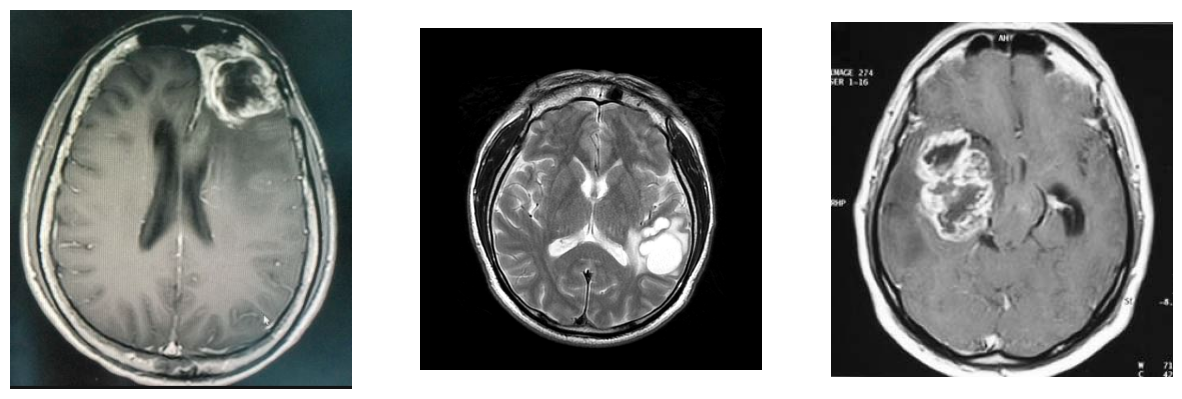

In [38]:
# Tumor MRI
#Selecting 3 images.
yes_dir = os.path.join(path, "yes")
yes_images = os.listdir(yes_dir)
img_paths = [os.path.join(yes_dir, yes_images[i]) for i in range(3)]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, img_path in zip(axes, img_paths):
    img = imread(img_path)

    ax.imshow(img)
    ax.axis('off') # Hide axes ticks
plt.show()

In [39]:
#plt.figure(figsize=(20,8))
#img = cv2.imread('Y1.jpg', 0)
#plt.imshow(img, cmap='gray')
#print(img.shape)

In [40]:
Yes_TUMOR = glob.glob('../content/drive/MyDrive/brain_tumor_dataset/to_train_validate/yes/*.jpg')
No_TUMOR = glob.glob('../content/drive/MyDrive/brain_tumor_dataset/to_train_validate/no/*.jpg')

In [41]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x

    return image_list

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Dataset Spliting
</h1>
</div>

In [42]:
x_train = load_image(Yes_TUMOR)
y_train = load_image(Yes_TUMOR)
x_test = load_image(No_TUMOR)

print(x_train.shape, x_test.shape)

(86, 258, 540, 1) (85, 258, 540, 1)


In [43]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(68, 258, 540, 1) (18, 258, 540, 1)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Creating Autoencoder Class
</h1>
</div>

In [44]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(lr=0.001)

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)

        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

        return Model(input_layer, output_layer)

    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1,
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#9FA7BD;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<h1 style="text-align: center;
           padding: 10px;
              color:white">

Model Training
</h1>
</div>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 258, 540, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 258, 540, 64)      640       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 129, 270, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 129, 270, 64)      36928     
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 258, 540, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 258, 540, 1)       577 

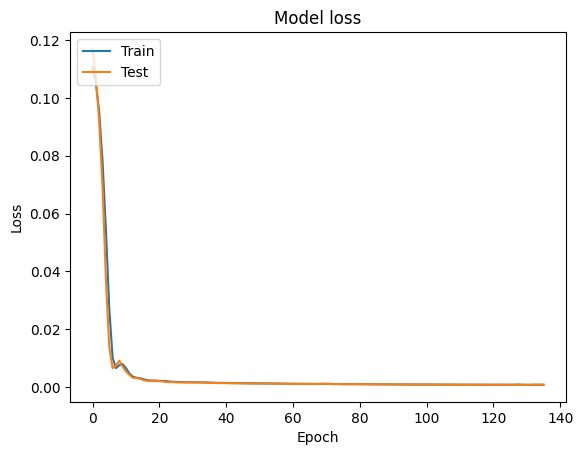

In [45]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=50, batch_size=20)

bold text
# **Predictions of Tumor**

In [46]:
# Evaluate the model using the test dataset
predictions = ae.eval_model(x_test) # x_test has only ima without tumor.


# Function to calculate the reconstruction error
def calculate_mse(original, reconstructed):
    mse = np.mean(np.square(original - reconstructed), axis=(1, 2, 3))
    return mse

# Calculate MSE for each image
mse_values = calculate_mse(x_test, predictions)

# Display MSE values
print("MSE values:", mse_values)


3/3 [==============================] - 0s 96ms/step
MSE values: [0.00049357 0.00027436 0.00075175 0.00072455 0.00043843 0.00043503
 0.00123959 0.0004957  0.00084351 0.00058768 0.00081934 0.00056565
 0.00136658 0.00100076 0.00074567 0.00097907 0.00075175 0.00048075
 0.00054704 0.00054704 0.00126823 0.00157383 0.00123273 0.00083902
 0.00031208 0.0006771  0.00047044 0.00082096 0.00129229 0.00041336
 0.00112706 0.00051053 0.00106868 0.00143131 0.00039127 0.0007256
 0.00057188 0.00049537 0.00045538 0.00066729 0.00035421 0.00027436
 0.00034374 0.0006984  0.00040196 0.00083902 0.00168899 0.00055001
 0.00147991 0.0004957  0.00088624 0.00042175 0.00037364 0.00091262
 0.00037364 0.00030834 0.00027836 0.00080657 0.00088813 0.00034575
 0.00106298 0.00080657 0.00077549 0.00050548 0.00045417 0.0006984
 0.00024657 0.00017197 0.00041769 0.0004057  0.00025481 0.00074335
 0.00026854 0.00043503 0.00114578 0.00375646 0.00014287 0.00035135
 0.00077621 0.00086451 0.00079261 0.00023529 0.00052255 0.00028627


In [47]:
# Determine a threshold
threshold = np.percentile(mse_values, 95)

# Predict whether each image has a tumor
has_tumor = mse_values > threshold

# Display predictions
print("Threshold:", threshold)
print("Predictions (True for likely having a tumor, False otherwise):", has_tumor)


Threshold: 0.0014183639590070896
Predictions (True for likely having a tumor, False otherwise): [False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False  True False False
 False False False False False False False False False False  True False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False]


In [48]:
# All images in x_test are non-tumor, hence all should be predicted as False
ground_truth_labels = np.zeros(len(x_test), dtype=bool)  # False for all


In [49]:
# Calculate mismatches between the predicted results and the ground truth
mismatches = has_tumor != ground_truth_labels
mismatch_indices = np.where(mismatches)[0]  # Get the indices of wrong predictions

# Display mismatch details
print("Mismatch indices (wrong predictions):", mismatch_indices)
print("MSE values of mismatches:", mse_values[mismatch_indices])


Mismatch indices (wrong predictions): [21 33 46 48 75]
MSE values of mismatches: [0.00157383 0.00143131 0.00168899 0.00147991 0.00375646]


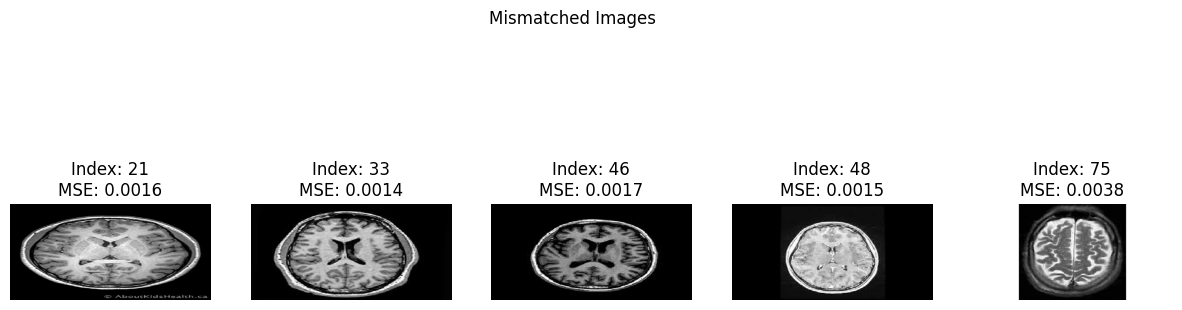

In [51]:
import matplotlib.pyplot as plt

def show_mismatched_images(images, indices, title="Mismatched Images"):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        ax = plt.subplot(1, len(indices), i + 1)
        plt.imshow(images[idx].reshape(258, 540), cmap='gray')
        plt.title(f"Index: {idx}\nMSE: {mse_values[idx]:.4f}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show mismatched images
show_mismatched_images(x_test, mismatch_indices)
